In [1]:
import warnings

warnings.filterwarnings(action='ignore')

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch import nn
from torch.utils.data import random_split, DataLoader
from forest_cover_change_detection.dataloaders.change import ChangeDetectionDataset
from forest_cover_change_detection.models.fc_ef import FCFE
from forest_cover_change_detection.trainer.train import Compile
from forest_cover_change_detection.metrics.accuracy import *

### Loading Data

In [2]:
data_set = ChangeDetectionDataset('../data/annotated',
                                  '../data/train.csv',
                                  concat=True,
                                  patched=False
                                  )

In [3]:
len(data_set)

334

torch.Size([6, 128, 128]) torch.Size([128, 128])


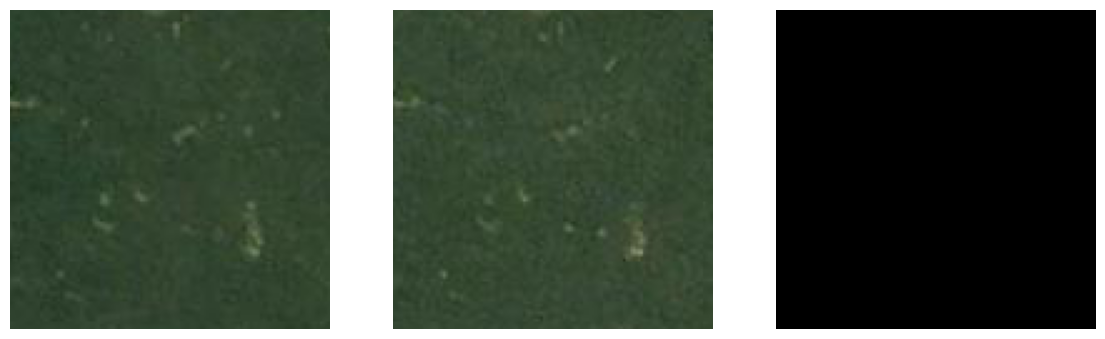

In [4]:
img, label = data_set[np.random.randint(0, data_set.__len__())]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 8), dpi=100)
axes = axes.ravel()

axes[0].imshow(img[:3, ::].permute(1, 2, 0).numpy())
axes[1].imshow(img[3:, ::].permute(1, 2, 0).numpy())
axes[2].imshow(label.numpy(), cmap='gray')

axes[0].axis(False)
axes[1].axis(False)
axes[2].axis(False)

print(img.shape, label.shape)

In [5]:
train_size = int(len(data_set) * 0.8)
test_size = len(data_set) - train_size

train_dataset, test_dataset = random_split(data_set, (train_size, test_size))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

len(train_dataloader), len(test_dataloader)

(9, 3)

### Modeling

In [6]:
model = FCFE(6, 3, classes=2)

In [7]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, cooldown=5)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=50)

compiled = Compile(model,
                   optimizer,
                   lr_scheduler=scheduler
                   )

In [8]:
compiled.summary((6, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             880
       BatchNorm2d-2         [-1, 16, 128, 128]              32
           Dropout-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,320
       BatchNorm2d-5         [-1, 16, 128, 128]              32
           Dropout-6         [-1, 16, 128, 128]               0
         MaxPool2d-7           [-1, 16, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           4,640
       BatchNorm2d-9           [-1, 32, 64, 64]              64
          Dropout-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 32, 64, 64]           9,248
      BatchNorm2d-12           [-1, 32, 64, 64]              64
          Dropout-13           [-1, 32, 64, 64]               0
        MaxPool2d-14           [-1, 32,

In [9]:
w = torch.load('../data/class_weight.pt')
w

tensor([0.0962, 1.9038], device='cuda:0')

In [10]:
results = compiled.train(train_dataloader,
                         nn.NLLLoss(w),
                         50,
                         test_dataloader)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.9480152395036485


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.8235085805257162


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.6887149877018399


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.8574636479218801


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.659305625491672


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.0400476257006328


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.6078399817148844


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.4739060799280803


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.5936265289783478


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.670159916083018


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.6208041674560971


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.3269353707631428


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.5861809915966458


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5561121006806692


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.5419407056437598


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.6476268668969473


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.5782273809115092


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.7060939073562622


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.5140174726645151


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.550524095694224


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.49047747254371643


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5317693253358206


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.5094620254304674


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.6675803860028585


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.47164907720353866


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5637444953123728


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.5235987537437015


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.6768115957578024


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.5223959154552884


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5412359833717346


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4907727738221486


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.4945368270079295


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.5157987475395203


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.49936381975809735


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.48756617969936794


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.45514514048894245


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.45548269814915127


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.7401402592658997


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.48019735349549186


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.6307153105735779


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.47678911023669773


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.4468681712945302


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.45865584082073635


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5862247248490652


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4852239787578583


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.619711180528005


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.45052802231576705


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5973074038823446


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.45826784438557094


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.44114355246225995


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.48067472378412884


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.4856905738512675


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.42734196450975204


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.8590592940648397


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4357007212109036


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.6113824645678202


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.43471188015407985


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.0306360125541687


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4700869123140971


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.8866240779558817


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4679492215315501


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.6428410609563192


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.46163827511999345


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.4848563273747761


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4570331772168477


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.6086015502611796


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.43353553944163853


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5793020129203796


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.47206732630729675


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.6743881702423096


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.44670453667640686


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.48128193616867065


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.48970548311869305


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5180899997552236


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4088880154821608


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.503216395775477


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.3703401717874739


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5467555224895477


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4641368157333798


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.642604390780131


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.44819488128026325


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5338962773482004


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.45537250571780735


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.4884720842043559


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.45180855525864494


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.49059832096099854


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4119534260696835


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.4630277156829834


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4178362786769867


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5969206790129343


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4080246388912201


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.6878290971120199


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4453161259492238


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5478411118189493


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4003189206123352


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.5236281752586365


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4356832173135545


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.6313178638617197


Training:   0%|          | 0/9 [00:00<?, ?it/s]

train loss: 0.4407908254199558


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val loss: 0.6582334339618683


In [11]:
torch.save(model, "../checkpoints/fcfe/final-model.pth")

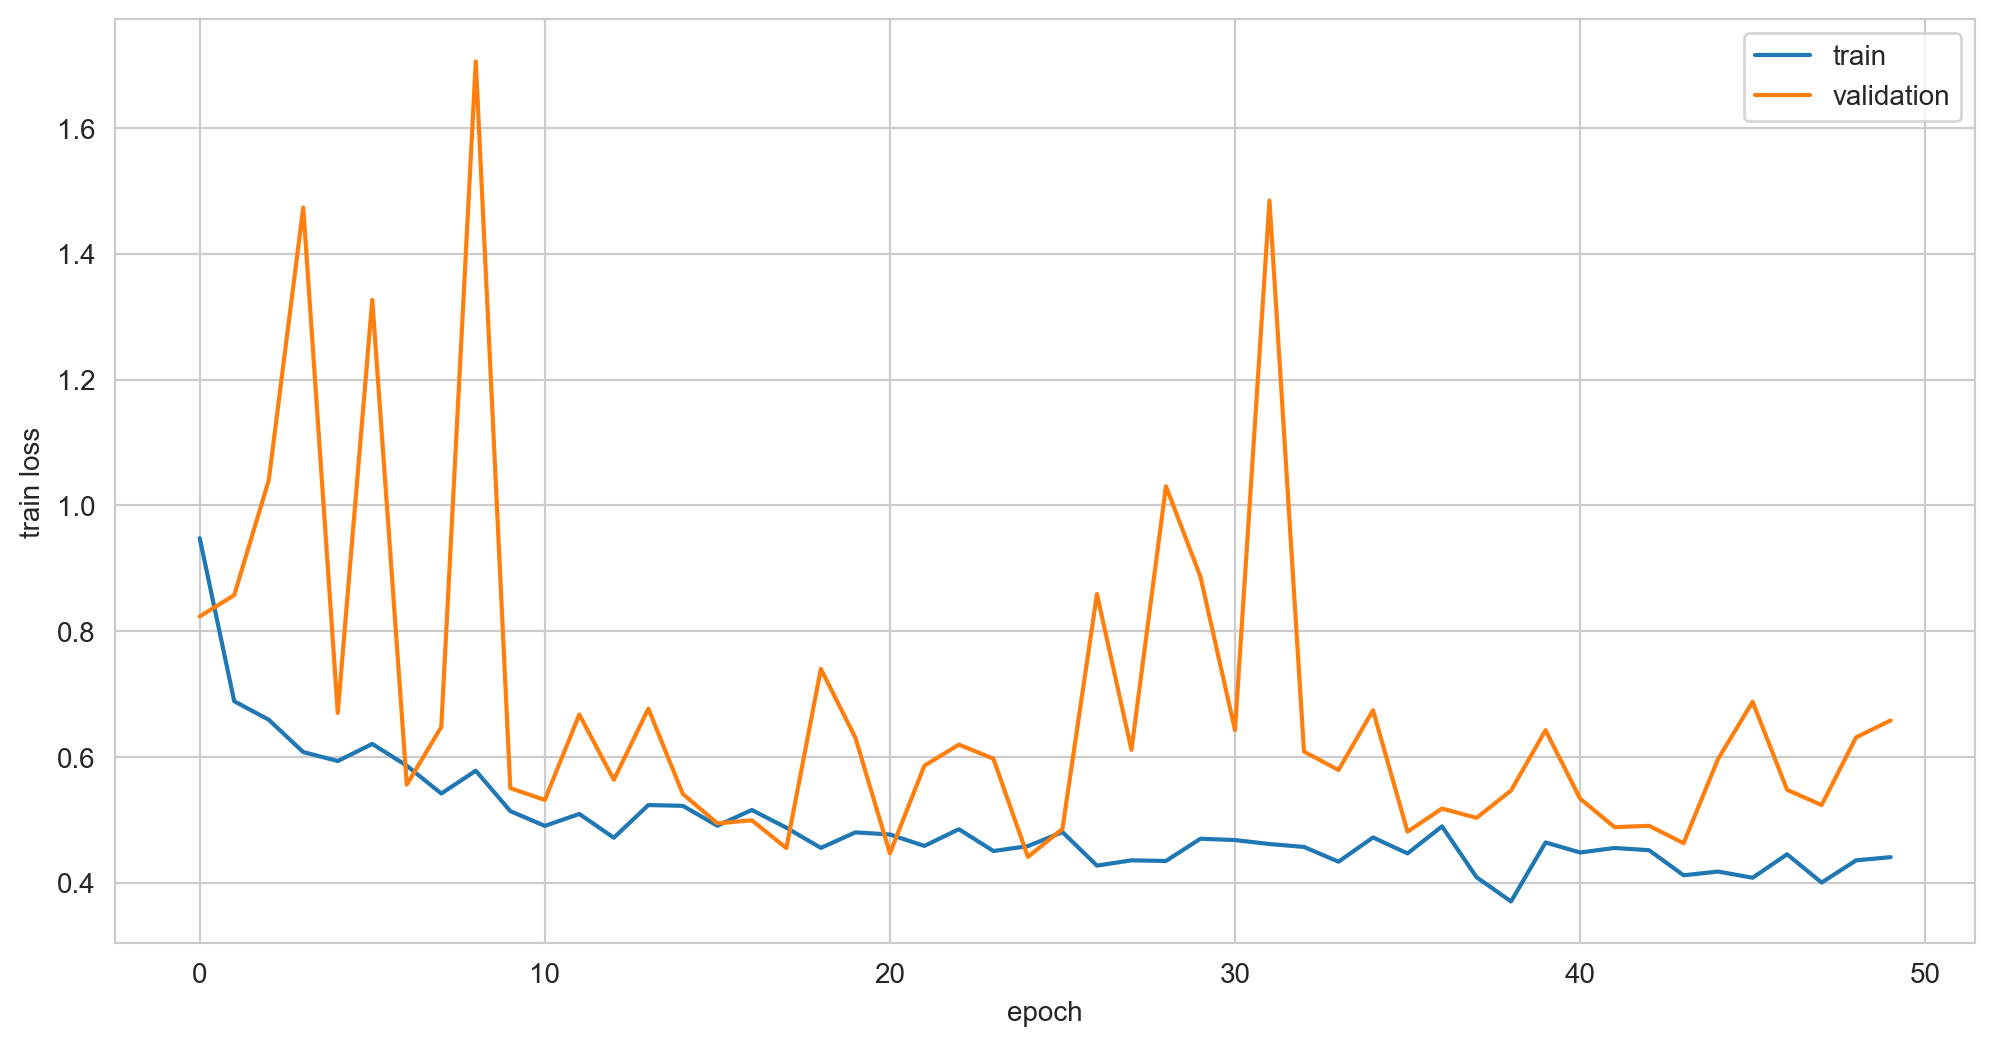

In [12]:
plt.figure(figsize=[12, 6], dpi=200)
sns.lineplot(x='epoch', y='train loss', data=results, label='train')
sns.lineplot(x='epoch', y='val loss', data=results, label='validation')
plt.show()

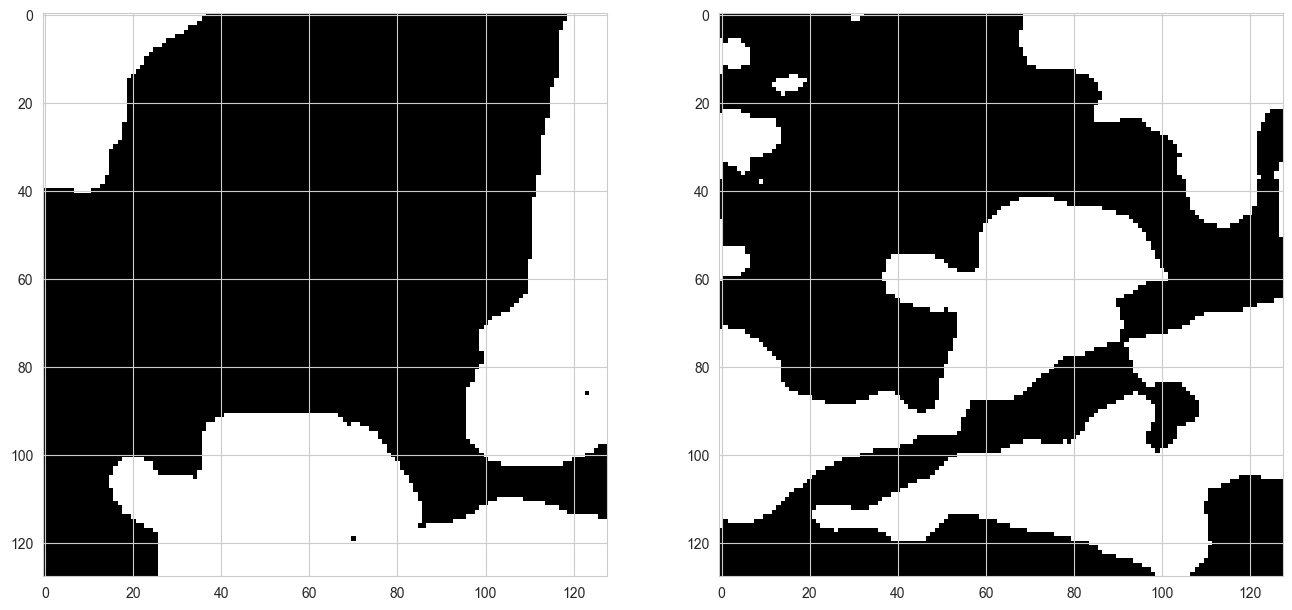

In [64]:
i = np.random.randint(0, len(test_dataset))
img = test_dataset[i][0]

with torch.no_grad():
    model.eval()
    logits = model(img.unsqueeze(0).to('cuda'))[0].cpu()
    pred = torch.argmax(torch.sigmoid(logits), dim=0)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_dataset[i][1], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')

In [65]:
pixel_accuracy(test_dataset[i][1], pred), kappa(test_dataset[i][1], pred), dice(test_dataset[i][1], pred)

(tensor(0.4152), tensor(0.0343), tensor(0.5596))